Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
# import all necessary packages
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import pathlib
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D , Activation, Dropout, Flatten, Dense, MaxPooling2D, Dense, Flatten, Dropout, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import Recall, Precision
import matplotlib.pyplot as plt
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import visualkeras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
# list all existing output folder
augumented_path = list(data_dir_train.glob('**/output'))
augumented_path

[WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output'),
 WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output')]

In [4]:
# remove the augumented output folder on training dataset if exist
try:
    import shutil
    for i,v in enumerate(augumented_path):
        print(v)
        shutil.rmtree(augumented_path[i].__str__()+'/')
except:
    print("must be permission denied or import shutil package not found or directory not found")

Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output
Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [6]:
# set seed to 123 on numy and tensor
seed=123
np.random.seed(123)
tf.random.set_seed(123)

rand = np.random.randint(50);

### Create a dataset

Define some parameters for the loader:

In [7]:
# Defining parameters for model
batch_size = 64
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

# 🔄 Image Preprocessing

> Before training, you'll first modify your images to be better suited for training a convolutional neural network. For this task you'll use the Keras `ImageDataGenerator` function to perform data preprocessing and data augmentation.

> - This class also provides support for basic data augmentation such as random horizontal flipping of images.
> - We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
> - The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).



In [8]:
sns.set_style('darkgrid')
def plotMetricgraph(model_arg):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,7)) #ax1,ax2,ax3 refer to 3 plots
    history_df = pd.DataFrame(model_arg.history)
    history_df.loc[1:, ['loss', 'val_loss']].plot(ax=ax1)
    history_df.loc[1:, ['accuracy', 'val_accuracy']].plot(ax=ax2)
    
    ax1.set_title('Training and Validation Loss')
    ax1.set(xlabel='Epoch #',ylabel='Loss')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set(xlabel='Epoch #',ylabel='Accuracy')

    plt.show()

In [9]:
def plotSparseMetricgraph(model_arg):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,7)) #ax1,ax2,ax3 refer to 3 plots
    history_df = pd.DataFrame(model_arg.history)
    history_df.loc[1:, ['loss', 'val_loss']].plot(ax=ax1)
    history_df.loc[1:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(ax=ax2)
    
    ax1.set_title('Training and Validation Loss')
    ax1.set(xlabel='Epoch #',ylabel='Loss')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set(xlabel='Epoch #',ylabel='Accuracy')

    plt.show()

In [10]:
def setTrainRsults(model_name,model_history):
    metric={}
    metric['Accuracy']=round(model_history.history['sparse_categorical_accuracy'][-1]*100,3)
    metric['Loss']=round(model_history.history['loss'][-1],3)
    model_train_eval[model_name] = metric

In [11]:
def setTestRsults(model_name,model, y_pred):
    metric = {}
    results = model.evaluate(test_ds)
    metric['Loss'] = round(results[0],3)
    metric['Accuracy'] = round(results[1]*100,3)
    model_test_eval[model_name] = metric

In [12]:
def evaluate_model(model):
    # Using the test dataset
    score = model.evaluate(train_ds)
    print('##############################')
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    print('##############################')
    # Using the validation dataset
    score = model.evaluate(val_ds)
    print('Val loss:', score[0])
    print('Val accuracy:', score[1])
    print('##############################')
    # Using the test dataset
    score = model.evaluate(test_ds)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('##############################')

In [13]:
# A custom logic to get layer configurationss for a model
def get_model_summary(model):
    
    # create an empty DataFrame
    model_summary_df = pd.DataFrame(columns={'Layer Name':'',
                                             'Filter':1,
                                             'Kernel':'',
                                             'Padding':'',
                                             'Stride':'',
                                             'Pool Size':'',
                                             'Type':'',
                                             'Rate':0.1})
    
    # iterate through all kayers from the built model
    for i,layer in enumerate(model.layers):
        row = {}
        layer_name = layer.name.split('_')[0].title()
        if 'conv' in layer.name:
            row = {'Layer Name':layer_name,'Filter' : layer.filters,'Kernel' : layer.kernel_size,'Stride' :layer.strides,'Padding' : layer.padding}
        elif 'activation' in layer.name:
            row = {'Layer Name':layer_name,'Type' : str(layer.activation)[10:-23]}
        elif 'pooling' in layer.name:
            row = {'Layer Name':layer.name.split('_')[0].title()+layer.name.split('_')[1].title(),'Pool Size':layer.pool_size,'Stride' :layer.strides,'Padding' : layer.padding}
        elif 'dense' in layer.name:
            row = {'Layer Name':layer_name,'Filter' : layer.units}
        elif 'dropout' in layer.name:
            row = {'Layer Name':layer_name,'Rate' : layer.rate}
        else:
            row = {'Layer Name':layer_name}
        model_summary_df = model_summary_df.append(row, ignore_index = True)
    # fill empty values with ''
    model_summary_df = model_summary_df.fillna('')
    
    _,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    # plot the layer type counts
    sns.countplot(y=model_summary_df['Layer Name'].values,ax=ax1);
    ax1.set(title='Layer Count',xticks=[0,1,2,3,4])
    # plot the filter number counts
    sns.countplot(y=model_summary_df.loc[~(model_summary_df['Filter'] ==''),'Filter'].values,ax=ax2);
    ax2.set(title='Filter Count',xticks=[0,1,2])
    
    # return the dataframe
    return model_summary_df

# 🤖 Model Building

> One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets.

## ✔️ Impact of imbalance data on loss function

> Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

> We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



> When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [14]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 20% validation split
  subset="training", # take train dataset
  seed=123,   # seed set to 123
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 20% validation split
  subset="validation", # take validation dataset
  seed=123,  # seed set to 123
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# Listing out all the classes of skin cancer and storing them in a list. 
# We are finding the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names

# set the count of number of unique classes
num_classes = len(class_names)

# preview the classes
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [17]:
# Loop through all the batches to find if any batch contains all the 9 classes in it as each batch contains
# only 32 records there might be chances of a batch not having 1 or more classes.
batch = None

# loop on each batch
for i in range(1,len(train_ds)+1):
    
    # extract records from the batch as image and labels
    batch = [(images, labels) for images, labels in train_ds.take(i)]
    
    # print batch number
    print("batch :"+str(i))
    
    # remove previosu batch data
    del batch[: i-1]
    
    # check length to see if all classes are present in the batch
    unique_classes = len(np.unique(batch[0][1]))
    
    # if found exit loop
    if unique_classes == 9:
        print("found all "+str(unique_classes)+" unique classes in the batch "+str(i)+", exiting loop...")
        break
    else:
        print("found "+str(unique_classes)+" unique classes")

batch :1
found all 9 unique classes in the batch 1, exiting loop...


In [18]:
# batch variable contains records from batch which contains all classes
# extract RGB chnnel matrix of an image from the batch
df_r = batch[0][0][1][:,:,0]
df_g = batch[0][0][1][:,:,1]
df_b = batch[0][0][1][:,:,2]

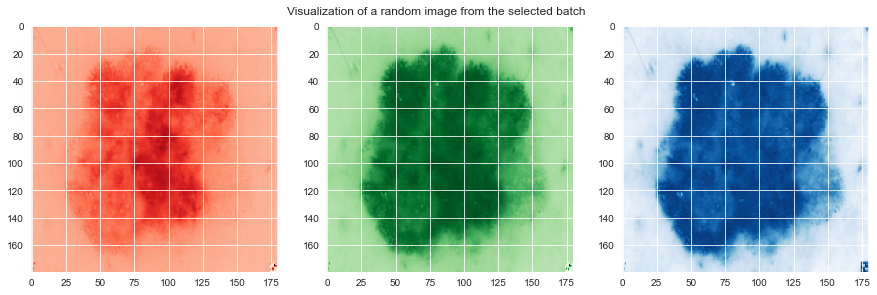

In [19]:
# visualize the image in RGB channel
plt.figure(figsize=(15,10))
i=1
for k,v in dict({'Reds_r':df_r,'Greens_r':df_g,'Blues_r':df_b}).items():
    ax = plt.subplot(1,3,i)
    plt.imshow(v.numpy(),cmap=k)
    i = i + 1
plt.suptitle("Visualization of a random image from the selected batch",x=0.5,y=0.7);

In [20]:
# get the class labels from the batch images
class_labels = pd.Series(batch[0][1]).drop_duplicates().sort_values()
class_labels

34    0
4     1
19    2
1     3
13    4
0     5
53    6
37    7
6     8
dtype: int32

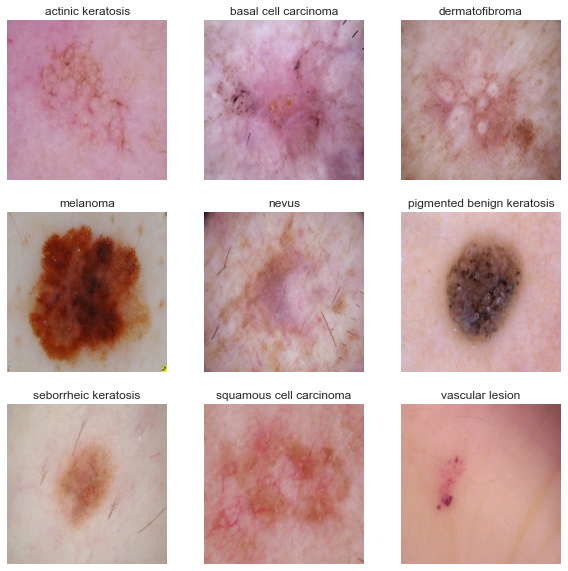

In [21]:
# visualize the image from each class
plt.figure(figsize=(10, 10))

# loop through all the classes and plot the image
for index, value in class_labels.iteritems():
    ax = plt.subplot(3, 3, value + 1)
    plt.imshow(batch[0][0][index].numpy().astype("uint8"))
    plt.title(class_names[value])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

# Data Augmentation

Overfitting generally occurs when the training data set is small with a model that could turn out to be complex. Data augmentation generilizies our training data by means of agumentation from your existing examples by using random transformations like rotation and zoom level that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [22]:
# lets add a function which can flip, rotate and zoom at random orientation and level on the given input image
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)), # flip the image horizontal
    layers.experimental.preprocessing.RandomRotation(0.05), # rotate 5% in random direction
    layers.experimental.preprocessing.RandomZoom(0.1), # zoom upto 10%
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

<ipython-input-23-e12f45467c4a>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


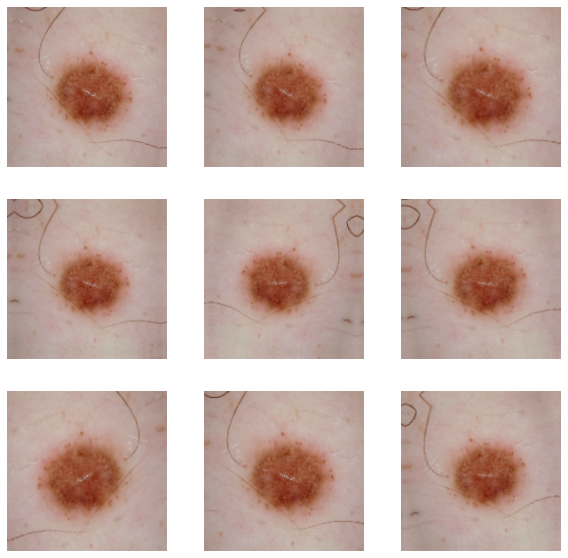

In [23]:
# plot a image with random augmentaion 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
class_map = pd.Series(class_names).to_dict()
class_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

In [25]:
batch = [labels.numpy() for images, labels in train_ds.take(len(train_ds))]

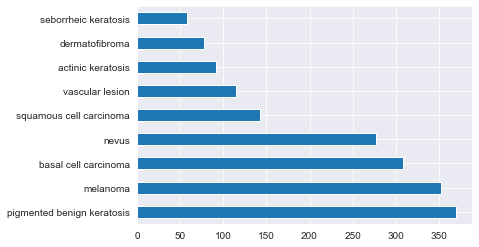

In [26]:
pd.Series(np.array(batch).flatten()).map(class_map).value_counts().plot(kind='barh');

In [27]:
# install Augumentor package
!pip install Augmentor

You should consider upgrading via the 'D:\Softwares\Anaconda3\envs\tf\python.exe -m pip install --upgrade pip' command.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
# set the path of our train dataset images
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# import Augumentor
import Augmentor

top_class_count = pd.Series(np.array(batch).flatten()).map(class_map).value_counts().max()

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + str(i))
    p.rotate(probability=0.75, max_left_rotation=25, max_right_rotation=25)
    p.flip_random(0.75)
    p.sample(top_class_count-pd.Series(np.array(batch).flatten()).map(class_map).value_counts()[i]+1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F00ED880>:   1%|▌                                                   | 15/1278 [00:00<00:15, 79.58 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x189F07791C0>: 100%|███████████████████████████████| 1278/1278 [00:03<00:00, 390.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F0127610>:   1%|▍                                                    | 9/1061 [00:00<00:27, 38.78 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F0138820>: 100%|█████████████████████████████████████████████████| 1061/1061 [00:02<00:00, 380.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F0746A60>:   1%|▌                                                   | 13/1293 [00:00<00:18, 69.82 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x189F07D3D30>: 100%|███████████████████████████████| 1293/1293 [00:03<00:00, 372.36 Samples/s]
Executing Pipeline:   0%|                                                                                                                    | 0/1018 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1899F72CEE0>: 100%|█████████████████████████████████████████████████| 1018/1018 [00:13<00:00, 74.52 Samples/s]
Executing Pipeline:   0%|                                                                                                                    | 0/1093 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1899F7270A0>: 100%|██████████████████████████████████████████████████| 1093/1093 [00:12<00:00, 87.35 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189E9A54520>:   1%|▋                                                   | 13/1000 [00:00<00:15, 62.01 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F04E4DF0>: 100%|█████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.92 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x189D4F1ADC0>:   0%|                                                    | 3/1312 [00:00<01:23, 15.69 Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x189F0310D60>: 100%|████████████████████████████████████████████████| 1312/1312 [00:07<00:00, 167.63 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F04AE190>:   1%|▋                                                   | 15/1228 [00:00<00:19, 61.11 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189D4EE3880>: 100%|█████████████████████████████████████████████████| 1228/1228 [00:03<00:00, 349.61 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189977B57C0>:   1%|▋                                                   | 18/1255 [00:00<00:15, 78.01 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189F0494C70>: 100%|█████████████████████████████████████████████████| 1255/1255 [00:03<00:00, 368.91 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
# get the length of number of samples generated in all outout folders
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

# preview total generated samples
print(image_count_train)

10538


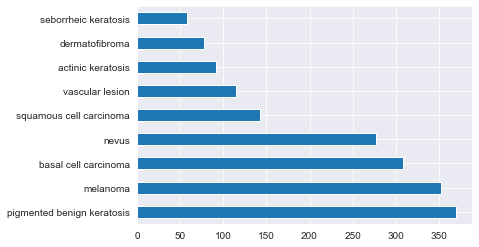

In [30]:
pd.Series(np.array(batch).flatten()).map(class_map).value_counts().plot(kind='barh');

###### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
# fetch all image path from output directory
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_131a6403-8919-4548-b4dc-89ca91c423f9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2ef431cc-5d55-4a49-9ee5-097de7baaf52.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3c0675c1-fba8-4ebd-93c5-63b830460b1a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_47ead259-7a5a-4dac-9427-4c4504f67870.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_541c5964-a651-4dfe-acdb-16adb1d14600.jpg']

In [32]:
# extract the directory names of the parent folder for output directory
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Custom Model

In [33]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12777 files belonging to 9 classes.
Using 10222 files for training.


In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12777 files belonging to 9 classes.
Using 2555 files for validation.


In [35]:
data_dir_test="Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=1)

Found 118 files belonging to 9 classes.


In [36]:
# initializing Autotune and converting the dataset to prefetch type
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [37]:
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3))

✔️ **Build a separate generator fo valid and test sets**

> Now we need to build a new generator for validation  and t esting data.

✔️ **Why can't use the same generator as for the training data?**

> Look back at the generator we wrote for the training data.
> - It normalizes each image per batch, meaning thatit uses batch statistics.
> - We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
> - Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).

> What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [54]:
# using the same model as before without augumentation layer
model = Sequential()
model.add(norm_layer)

model.add(Conv2D(16, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3),padding='valid'))
model.add(Activation('softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.05))

model.add(layers.Flatten())
model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_3 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 128)      

### Compiling the model

In [55]:
### set Optimiser and loss function as ADAM and SparceCategorialCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["sparse_categorical_accuracy"])


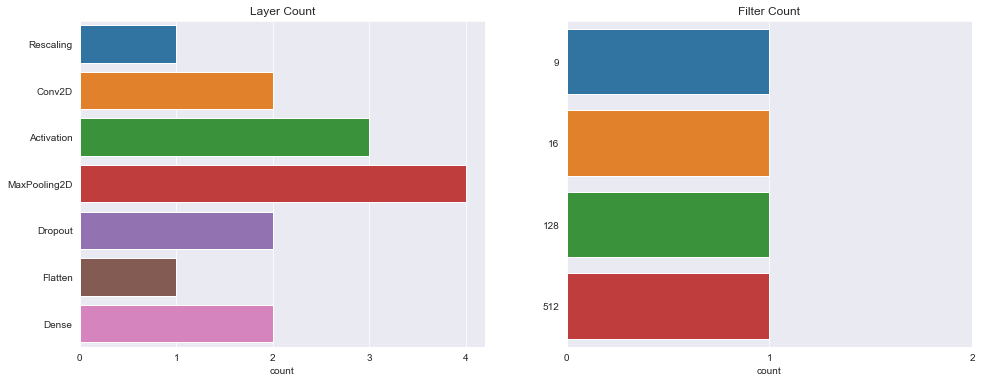

In [56]:
model_summary = get_model_summary(model)

# Preview model summary
#model_summary

In [57]:
# initialize the number of epochs to 30 and fit the built model with dataset
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
160/160 [==============================] - 4s 19ms/step - loss: 2.2358 - sparse_categorical_accuracy: 0.1144 - val_loss: 1.9073 - val_sparse_categorical_accuracy: 0.2607
Epoch 2/60
160/160 [==============================] - 3s 18ms/step - loss: 1.8496 - sparse_categorical_accuracy: 0.2530 - val_loss: 1.6835 - val_sparse_categorical_accuracy: 0.3276
Epoch 3/60
160/160 [==============================] - 3s 17ms/step - loss: 1.6490 - sparse_categorical_accuracy: 0.3449 - val_loss: 1.4974 - val_sparse_categorical_accuracy: 0.3945
Epoch 4/60
160/160 [==============================] - 3s 16ms/step - loss: 1.5354 - sparse_categorical_accuracy: 0.3997 - val_loss: 1.4742 - val_sparse_categorical_accuracy: 0.3953
Epoch 5/60
160/160 [==============================] - 3s 17ms/step - loss: 1.4648 - sparse_categorical_accuracy: 0.4192 - val_loss: 1.4366 - val_sparse_categorical_accuracy: 0.4258
Epoch 6/60
160/160 [==============================] - 3s 16ms/step - loss: 1.4097 - sparse_cate

In [58]:
model.save("model.h5")

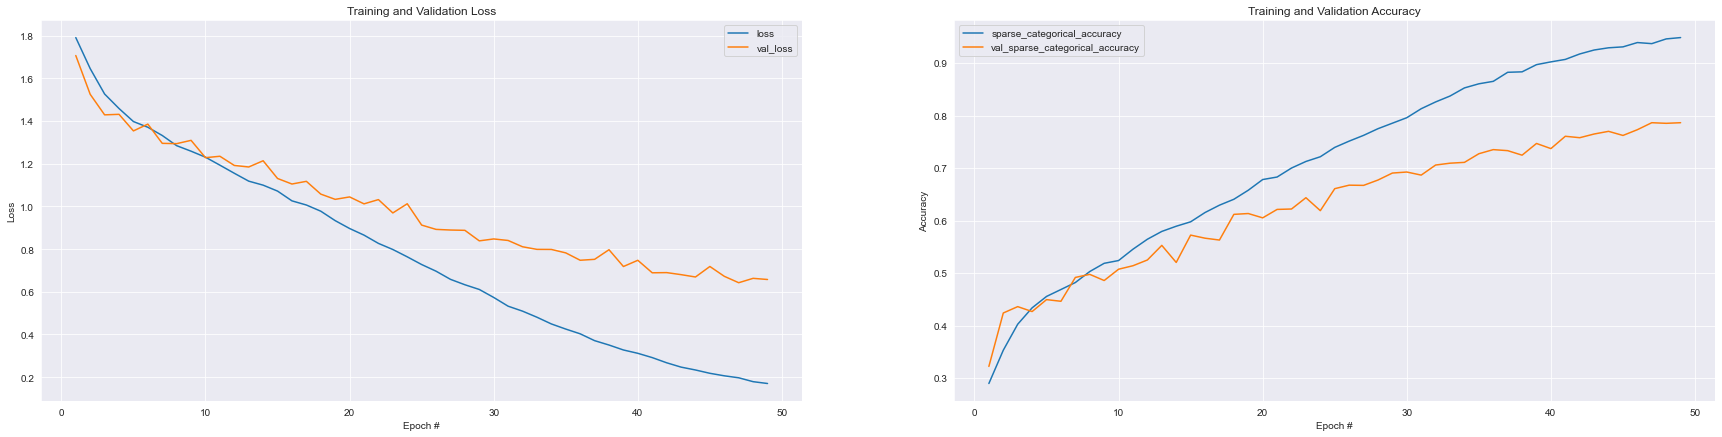

In [43]:
plotSparseMetricgraph(history)

In [44]:
#plotMetricgraph(history)

In [45]:
model_train_eval = {} #variable to save each train of the model results
model_test_eval = {} #variable to save each test of the model results

In [46]:
setTrainRsults("CustomeModel",history)

In [47]:
evaluate_model(model)

160/160 [==============================] - 1s 8ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.9634
##############################
Train loss: 0.1328696757555008
Train accuracy: 0.9634122252464294
##############################
40/40 [==============================] - 0s 8ms/step - loss: 0.6573 - sparse_categorical_accuracy: 0.7863
Val loss: 0.6573077440261841
Val accuracy: 0.7863013744354248
##############################
118/118 [==============================] - 1s 6ms/step - loss: 3.3838 - sparse_categorical_accuracy: 0.3898
Test loss: 3.383754253387451
Test accuracy: 0.38983049988746643
##############################


In [48]:
#Confution Matrix and Classification Report
Y_pred = model.predict(test_ds)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)

In [49]:
setTestRsults("CustomeModel",model, y_pred)

118/118 [==============================] - 1s 6ms/step - loss: 3.3838 - sparse_categorical_accuracy: 0.3898


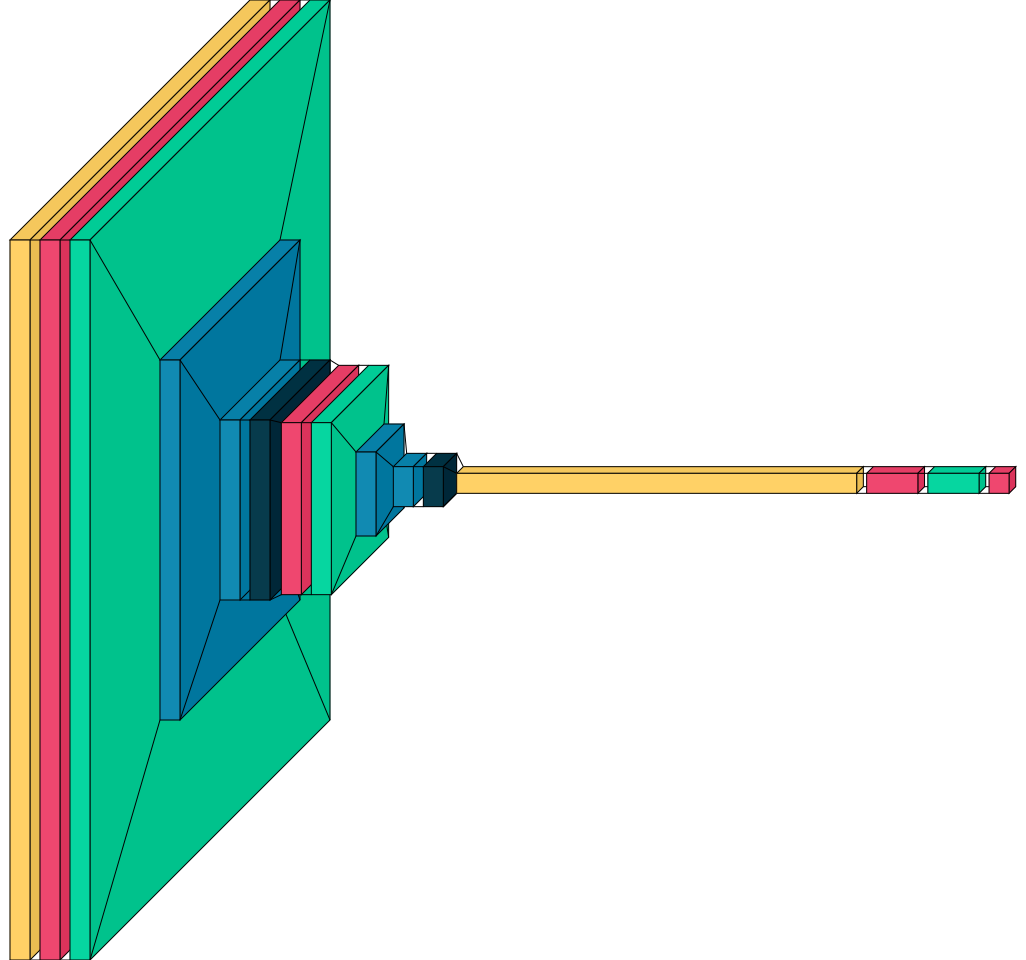

In [50]:
visualkeras.layered_view(model)

In [51]:
pd.DataFrame(model_train_eval).T

,Accuracy,Loss
CustomeModel,94.844,0.17


In [52]:
pd.DataFrame(model_test_eval).T

,Accuracy,Loss
CustomeModel,38.983,3.384


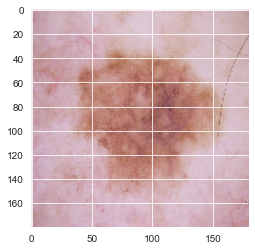

class_names:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
result: [[ -1.176456     0.46671623  -2.383607    -2.0522847   -0.26443005
    6.382082    -6.8486066    2.2066336  -21.867481  ]]
result: pigmented benign keratosis


In [53]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
img_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024547.jpg"
img = image.load_img(img_path, target_size=(180, 180))
plt.imshow(img)
plt.show()
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
#img_preprocessed = preprocess_input(img_batch)
#load saved model
model = load_model("model.h5");
result = model.predict(img_batch)
print("class_names: ", class_names)
print("result:", result)
result = np.argmax(result, axis=-1)
print("result:", class_names[result[0]])